# Cross section computation using the Discrete Integral Transform (DIT) for rapid spectral synthesis

We demonstarte the Discrete Integral Transform (DIT) method proposed by D.C.M van den Bekerom and E.Pannier. DIT takes advantage especially for the case that the number of the molecular line is large (typically > 10,000). We here compare the results by DIT with the direct computation (LPF).  



In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
plt.style.use('bmh')

In [2]:
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb

# Setting wavenumber bins and loading HITRAN database
nus=np.linspace(1900.0,2300.0,350000,dtype=np.float64) 
mdbCO=moldb.MdbHit('05_hit12.par',nus)

# set T, P and partition function
Mmol=28.01 # molecular weight
Tfix=1000.0 # we assume T=1000K
Pfix=1.e-3 # we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere.
qt=mdbCO.Qr_layer_HAPI([Tfix])[0]

# compute Sij, gamma_L, sigmaD 
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A)
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

DIT uses a grid of sigmaD, gammaL, and wavenumber. set_ditgrid makes a 1D grid for sigmaD and gamma.

In [3]:
from exojax.spec.dit import set_ditgrid
sigmaD_grid=set_ditgrid(sigmaD)
gammaL_grid=set_ditgrid(gammaL)

# we can change the resolution using res option
#sigmaD_grid=set_ditgrid(sigmaD,res=0.1)
#gammaL_grid=set_ditgrid(gammaL,res=0.1)

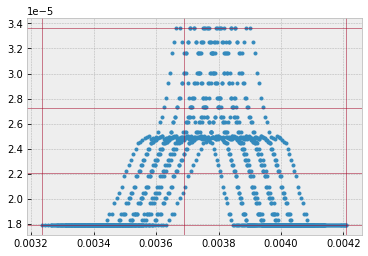

In [4]:
#show the grids
plt.plot(sigmaD,gammaL,".")
for i in sigmaD_grid:
    plt.axvline(i,lw=1,alpha=0.5,color="C1")
for i in gammaL_grid:
    plt.axhline(i,lw=1,alpha=0.5,color="C1")

For DIT in exojax, we also need to specify Nfold and precompute "dLarray". 
The aliasing effect may results in some negative values in the computed cross section, in particular, when the grid resolution is comparable or smaller than to the line width. We can avoid this effect by including the aliased part of the distribution. Nfold is the number of aliasing to be included. dLarray is just a list (1,2,3,...,Nfold)/dnu, where dnu is the wavenumber interval. We can use dit.make_dLarray to compute dLarray. Also, we need to precompute the contribution for wavenumber. These can be computed using init_dit. 

In [7]:
from exojax.spec import initspec 
cnu,indexnu,dLarray=initspec.init_dit(mdbCO.nu_lines,nus)

Then, let's compute a cross section!

In [16]:
from exojax.spec.dit import xsvector
xs=xsvector(cnu,indexnu,dLarray,sigmaD,gammaL,Sij,nus,sigmaD_grid,gammaL_grid)

Also, we here try the direct computation using LPF for the comparison purpose

In [10]:
from exojax.spec import xsection
xsv=xsection(nus,mdbCO.nu_lines,sigmaD,gammaL,Sij,memory_size=30) 

100%|████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 28.79it/s]


The difference is <~ 1%.

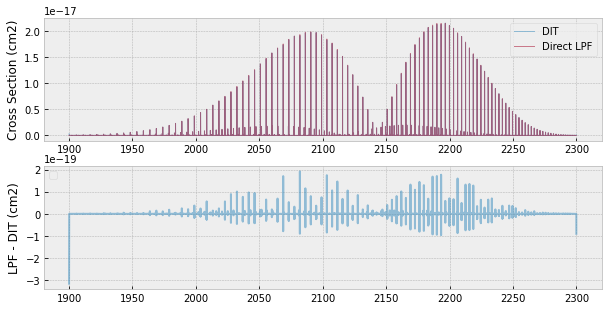

In [15]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=1,alpha=0.5,label="DIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct LPF")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
#plt.plot(nus,xsv-xs,lw=2,alpha=0.5,label="precomputed")
plt.plot(nus,xsv-xs,lw=2,alpha=0.5)
plt.ylabel("LPF - DIT (cm2)")
plt.legend(loc="upper left")
plt.show()